# Test Parameter Estimator

Test the ParameterEstimator class with a subset of experimental conditions and fitted parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parameter_estimator import ParameterEstimator

## Load PETAb Data

In [2]:
# Load PETAb files
conditions_df = pd.read_csv('../petab_files/conditions.tsv', sep='\t')
measurements_df = pd.read_csv('../petab_files/measurements.tsv', sep='\t')
observables_df = pd.read_csv('../petab_files/observables.tsv', sep='\t')
parameters_df = pd.read_csv('../petab_files/parameters.tsv', sep='\t')

print(f"Original data:")
print(f"  {len(conditions_df)} experimental conditions")
print(f"  {len(measurements_df)} measurements")

Original data:
  6 experimental conditions
  84 measurements


## Create Parameter Estimator

In [3]:
# Create estimator with filtered data
estimator = ParameterEstimator(
    bngl_file="../variable_JAK_STAT_SOCS_degrad_model.bngl",
    conditions_df=conditions_df,
    measurements_df=measurements_df,
    observables_df=observables_df,
    parameters_df=parameters_df
)

print(f"\nEstimable parameters: {len(estimator.estimable_params)}")

Initialized estimator with 46 estimable parameters
Timepoints: [ 0. 10. 20. 30. 45. 60. 90.]

Estimable parameters: 46


## Load Fitted Parameters

In [4]:
# Load fitted parameter sets and remove duplicates
param_sets_df_full = pd.read_csv('../param_sets.csv')
print(f"Loaded {len(param_sets_df_full)} parameter sets (with redundancy)")

# L1_0 and L2_0 vary by condition, so exclude them when checking for duplicates
# We only want unique sets of the actual fitted parameters
cols_to_check = [col for col in param_sets_df_full.columns if col not in ['L1_0', 'L2_0']]
param_sets_df = param_sets_df_full.drop_duplicates(subset=cols_to_check).reset_index(drop=True)

print(f"Unique parameter sets: {len(param_sets_df)}")
print(f"Redundancy factor: {len(param_sets_df_full) / len(param_sets_df):.1f}x")

# Use first parameter set
fitted_dict = param_sets_df.iloc[0].to_dict()

# Create parameter dict for estimator (only estimable params)
fitted_dict_subset = {}
for param_name in estimator.estimable_params:
    if param_name in fitted_dict:
        fitted_dict_subset[param_name] = fitted_dict[param_name]
    else:
        # Use nominal value for missing parameters
        fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']

print(f"\nParameter set 0 loaded")
print(f"Sample parameters:")
for i, (param, value) in enumerate(list(fitted_dict_subset.items())[:5]):
    print(f"  {param}: {value:.6g}")
print(f"  ...")

Loaded 12402 parameter sets (with redundancy)
Unique parameter sets: 2067
Redundancy factor: 6.0x

Parameter set 0 loaded
Sample parameters:
  il10_complex_jak1_binding: 259.69
  SOCS3_il6r_unbinding: 0.39669
  il6_jak1_med_STAT1_act: 2.32e-05
  pSTAT1_rec_dissoc: 1.0407
  il6_complex_jak2_binding: 0.026832
  ...


## Convert to Parameter Vector and Compute NLLH

In [5]:
# Convert to parameter vector
fitted_vector = estimator.params_to_vector(fitted_dict_subset)

print("Computing negative log-likelihood...")
nllh = estimator.compute_nllh(fitted_vector, verbose=True)
print(f"\nNegative log-likelihood: {nllh:.4f}")

Computing negative log-likelihood...
Computed scaling factors: sf_pSTAT1=27065.25, sf_pSTAT3=281.03
NLLH = 451.5576 (84 datapoints)

Negative log-likelihood: 451.5576


## Plot Fit vs Data

Visualize model predictions vs experimental data for all 6 conditions.

In [6]:
# Evaluate NLLH for multiple parameter sets
import time

# Choose how many parameter sets to evaluate
n_sets_to_evaluate = 2067  # Adjust this number as needed

print(f"Evaluating NLLH for {n_sets_to_evaluate} parameter sets...")
print(f"Total available: {len(param_sets_df)} parameter sets\n")

nllh_values = []
param_set_indices = []
failed_indices = []

start_time = time.time()

for idx in range(min(n_sets_to_evaluate, len(param_sets_df))):
    # Get parameter set
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    
    # Create parameter dict for estimator (only estimable params, no sf_ or sigma_)
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            # Use nominal value for missing parameters
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    # Convert to parameter vector
    try:
        param_vector = estimator.params_to_vector(fitted_dict_subset)
        
        # Compute NLLH
        nllh = estimator.compute_nllh(param_vector, verbose=False)
        
        if np.isfinite(nllh):
            nllh_values.append(nllh)
            param_set_indices.append(idx)
        else:
            failed_indices.append(idx)
            
    except Exception as e:
        print(f"Error evaluating parameter set {idx}: {e}")
        failed_indices.append(idx)
    
    # Progress update every 10 sets
    if (idx + 1) % 10 == 0:
        elapsed = time.time() - start_time
        rate = (idx + 1) / elapsed
        remaining = (n_sets_to_evaluate - idx - 1) / rate
        print(f"  Completed {idx + 1}/{n_sets_to_evaluate} ({100*(idx+1)/n_sets_to_evaluate:.1f}%) - "
              f"Est. time remaining: {remaining:.1f}s")

elapsed_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"Evaluation complete!")
print(f"  Total time: {elapsed_time:.1f} seconds")
print(f"  Successful: {len(nllh_values)}/{n_sets_to_evaluate}")
print(f"  Failed: {len(failed_indices)}/{n_sets_to_evaluate}")
print(f"\nNLLH Statistics:")
print(f"  Min:    {np.min(nllh_values):.2f}")
print(f"  Median: {np.median(nllh_values):.2f}")
print(f"  Mean:   {np.mean(nllh_values):.2f}")
print(f"  Max:    {np.max(nllh_values):.2f}")
print(f"  Std:    {np.std(nllh_values):.2f}")

# Find best parameter set
best_idx = param_set_indices[np.argmin(nllh_values)]
best_nllh = np.min(nllh_values)
print(f"\nBest parameter set: #{best_idx} with NLLH = {best_nllh:.2f}")

Evaluating NLLH for 2067 parameter sets...
Total available: 2067 parameter sets

  Completed 10/2067 (0.5%) - Est. time remaining: 99.8s
  Completed 20/2067 (1.0%) - Est. time remaining: 97.2s
  Completed 30/2067 (1.5%) - Est. time remaining: 96.3s
  Completed 40/2067 (1.9%) - Est. time remaining: 98.0s
  Completed 50/2067 (2.4%) - Est. time remaining: 97.4s
  Completed 60/2067 (2.9%) - Est. time remaining: 96.5s
  Completed 70/2067 (3.4%) - Est. time remaining: 96.1s
  Completed 80/2067 (3.9%) - Est. time remaining: 95.3s
  Completed 90/2067 (4.4%) - Est. time remaining: 94.6s
  Completed 100/2067 (4.8%) - Est. time remaining: 94.2s
  Completed 110/2067 (5.3%) - Est. time remaining: 94.1s
  Completed 120/2067 (5.8%) - Est. time remaining: 93.8s
  Completed 130/2067 (6.3%) - Est. time remaining: 93.3s
  Completed 140/2067 (6.8%) - Est. time remaining: 92.8s
  Completed 150/2067 (7.3%) - Est. time remaining: 92.0s
  Completed 160/2067 (7.7%) - Est. time remaining: 91.3s
  Completed 170/

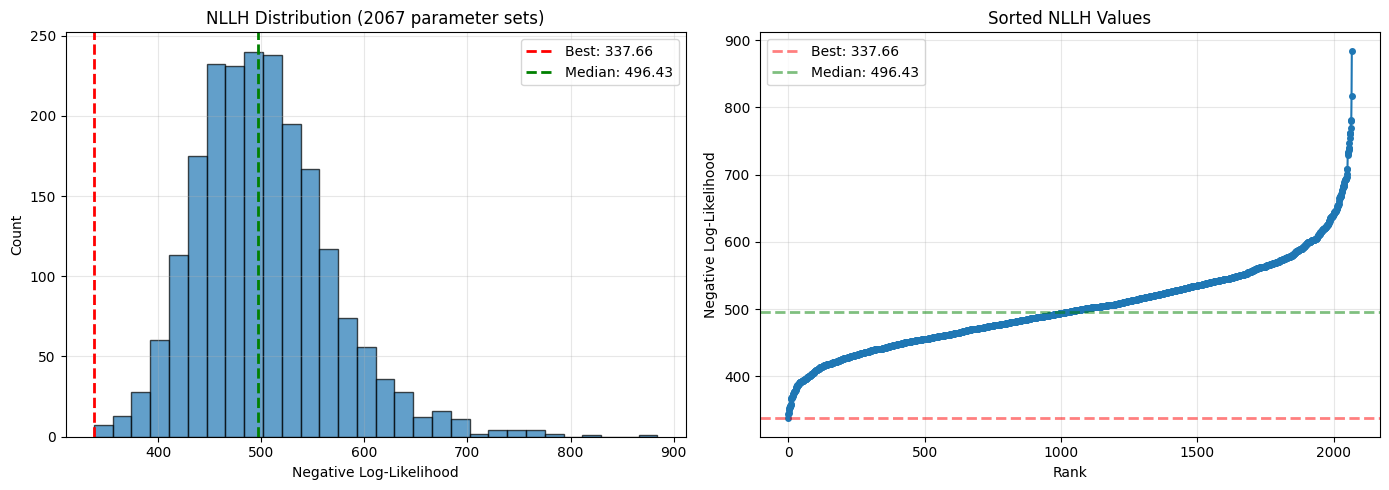


Top 10 parameter sets (lowest NLLH):
   1. Parameter set #1647: NLLH = 337.66
   2. Parameter set #1899: NLLH = 343.45
   3. Parameter set #1763: NLLH = 345.75
   4. Parameter set # 944: NLLH = 349.74
   5. Parameter set #1943: NLLH = 352.50
   6. Parameter set #1331: NLLH = 353.86
   7. Parameter set #1814: NLLH = 355.16
   8. Parameter set # 619: NLLH = 355.97
   9. Parameter set # 625: NLLH = 356.74
  10. Parameter set #1699: NLLH = 357.74


In [7]:
# Plot NLLH distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(nllh_values, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(best_nllh, color='red', linestyle='--', linewidth=2, label=f'Best: {best_nllh:.2f}')
ax.axvline(np.median(nllh_values), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {np.median(nllh_values):.2f}')
ax.set_xlabel('Negative Log-Likelihood')
ax.set_ylabel('Count')
ax.set_title(f'NLLH Distribution ({len(nllh_values)} parameter sets)')
ax.legend()
ax.grid(True, alpha=0.3)

# Sorted NLLH values
ax = axes[1]
sorted_nllh = np.sort(nllh_values)
ax.plot(range(len(sorted_nllh)), sorted_nllh, 'o-', markersize=4)
ax.axhline(best_nllh, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Best: {best_nllh:.2f}')
ax.axhline(np.median(nllh_values), color='green', linestyle='--', linewidth=2, alpha=0.5,
           label=f'Median: {np.median(nllh_values):.2f}')
ax.set_xlabel('Rank')
ax.set_ylabel('Negative Log-Likelihood')
ax.set_title('Sorted NLLH Values')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 parameter sets (lowest NLLH):")
top_10_idx = np.argsort(nllh_values)[:10]
for rank, idx in enumerate(top_10_idx, 1):
    param_idx = param_set_indices[idx]
    nllh_val = nllh_values[idx]
    print(f"  {rank:2d}. Parameter set #{param_idx:4d}: NLLH = {nllh_val:.2f}")

Plotting best parameter set (#1647) with NLLH = 337.66

Plotting fit for 6 conditions


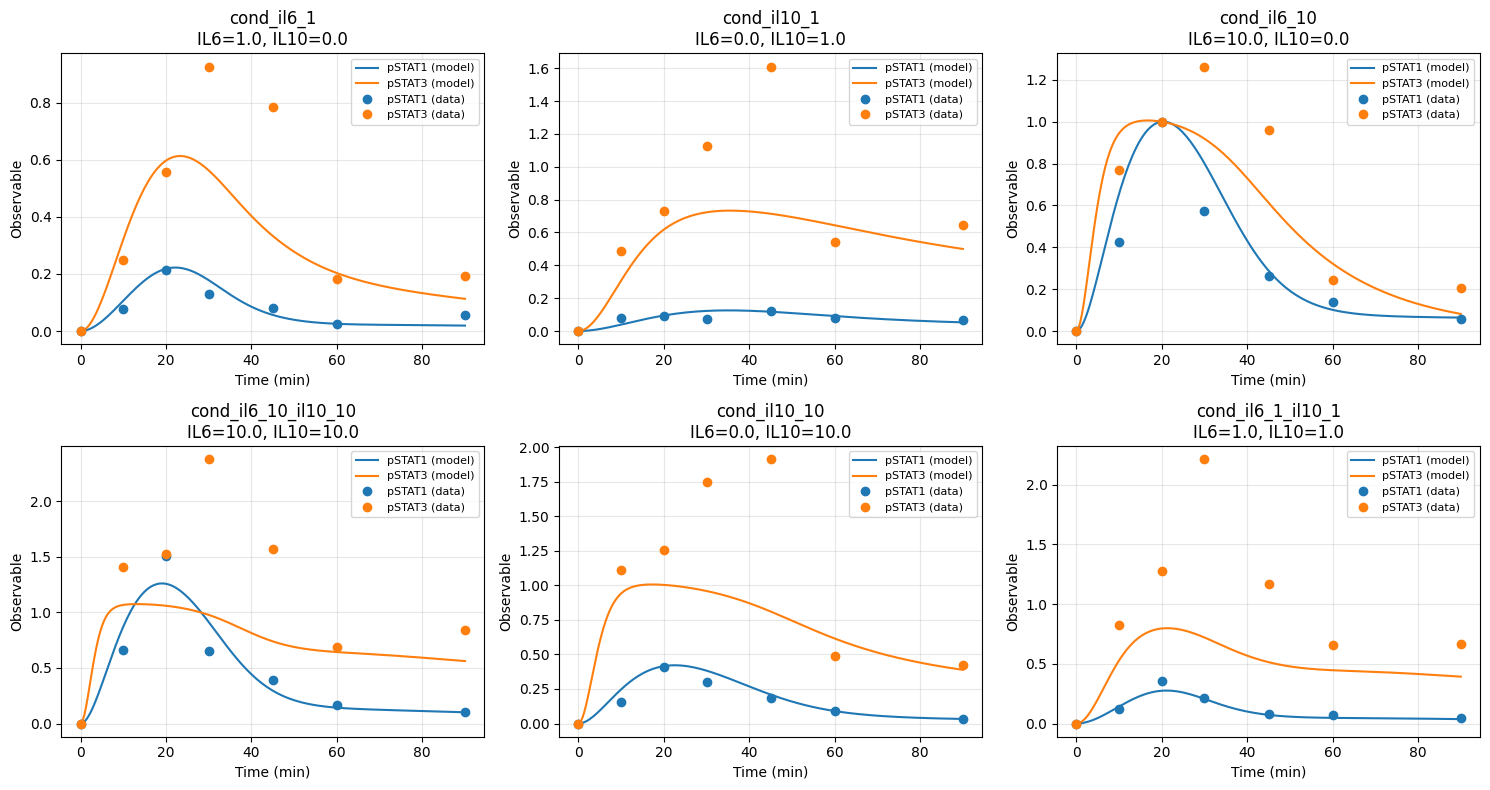

In [8]:
# Plot the best fit
print(f"Plotting best parameter set (#{best_idx}) with NLLH = {best_nllh:.2f}\n")

# Get best parameter set
best_fitted_dict = param_sets_df.iloc[best_idx].to_dict()
best_fitted_dict_subset = {}
for param_name in estimator.estimable_params:
    if param_name in best_fitted_dict:
        best_fitted_dict_subset[param_name] = best_fitted_dict[param_name]
    else:
        best_fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']

# Convert to vector
best_param_vector = estimator.params_to_vector(best_fitted_dict_subset)

# Plot the fit
estimator.plot_fit(best_param_vector)

## Compare Multiple Parameter Sets

You can also compare fits from different parameter sets.


Best parameter set: #29
Computed scaling factors: sf_pSTAT1=53504.95, sf_pSTAT3=440.16
NLLH = -21.7414 (84 datapoints)

Plotting best fit...
Plotting fit for 6 conditions


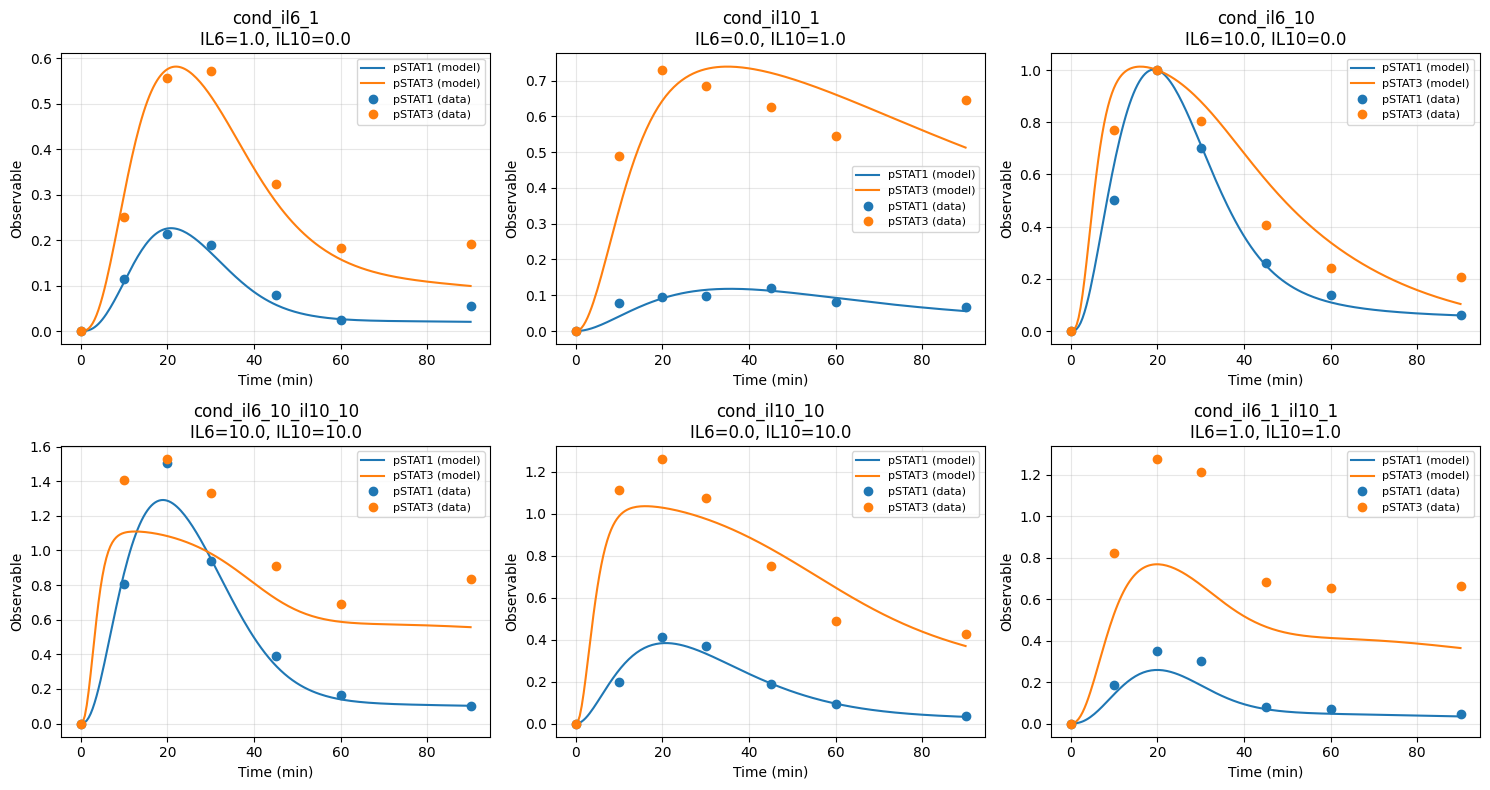


Median parameter set: #1033
Computed scaling factors: sf_pSTAT1=79.46, sf_pSTAT3=274.61
NLLH = 127.8283 (84 datapoints)

Plotting median fit...
Plotting fit for 6 conditions


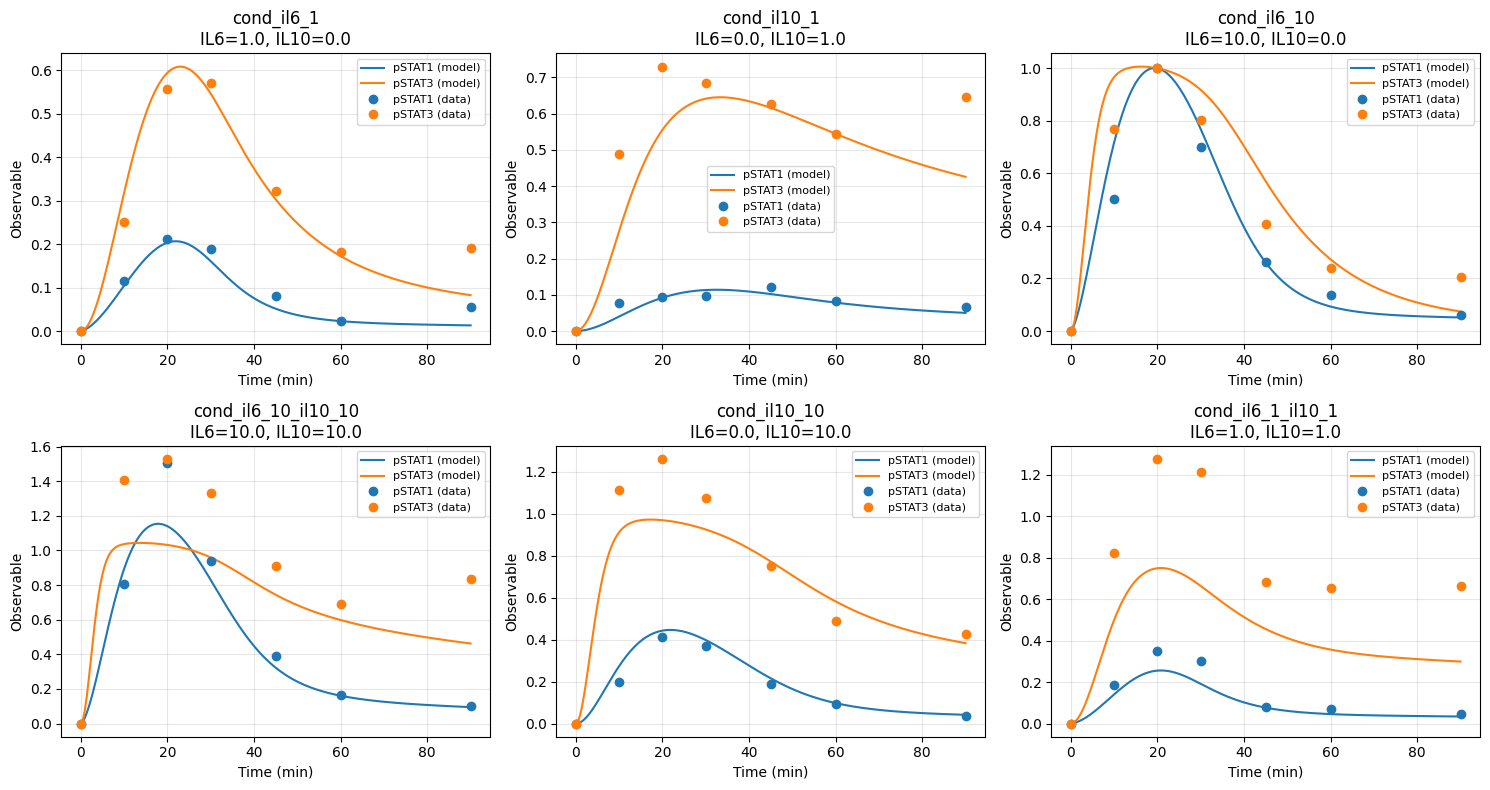


Worst parameter set: #138
Computed scaling factors: sf_pSTAT1=8317.94, sf_pSTAT3=221.84
NLLH = 394.2010 (84 datapoints)

Plotting worst fit...
Plotting fit for 6 conditions


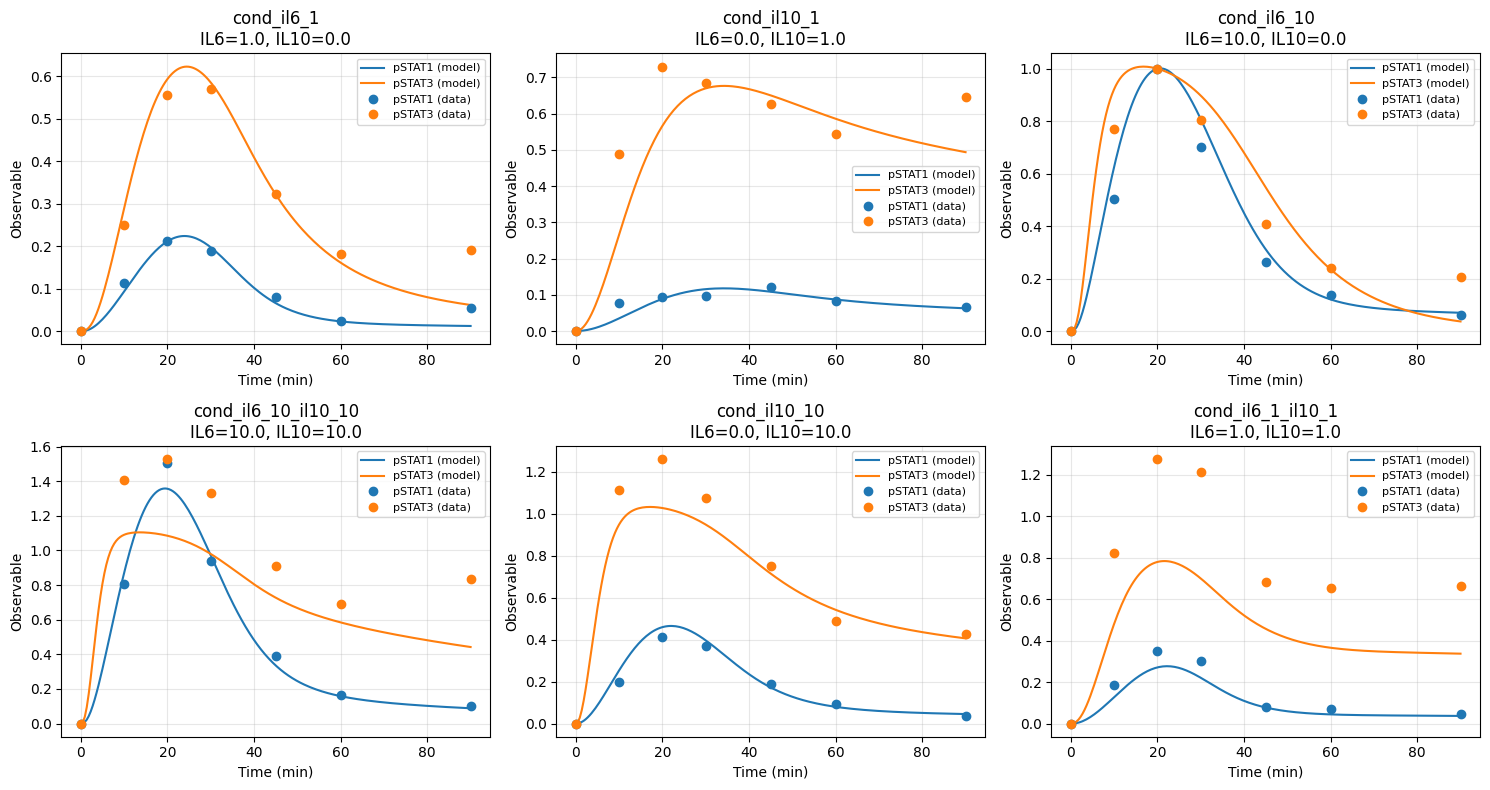

In [10]:
# Compare best, median, and worst fits
indices_to_compare = [
    ('Best', param_set_indices[np.argmin(nllh_values)]),
    ('Median', param_set_indices[len(nllh_values)//2]),
    ('Worst', param_set_indices[np.argmax(nllh_values)])
]

for label, idx in indices_to_compare:
    print(f"\n{label} parameter set: #{idx}")
    
    # Get parameter set
    compare_dict = param_sets_df.iloc[idx].to_dict()
    compare_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in compare_dict:
            compare_dict_subset[param_name] = compare_dict[param_name]
        else:
            compare_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    # Convert to vector and compute NLLH
    compare_vector = estimator.params_to_vector(compare_dict_subset)
    compare_nllh = estimator.compute_nllh(compare_vector, verbose=True)
    
    # Plot
    print(f"\nPlotting {label.lower()} fit...")
    estimator.plot_fit(compare_vector)

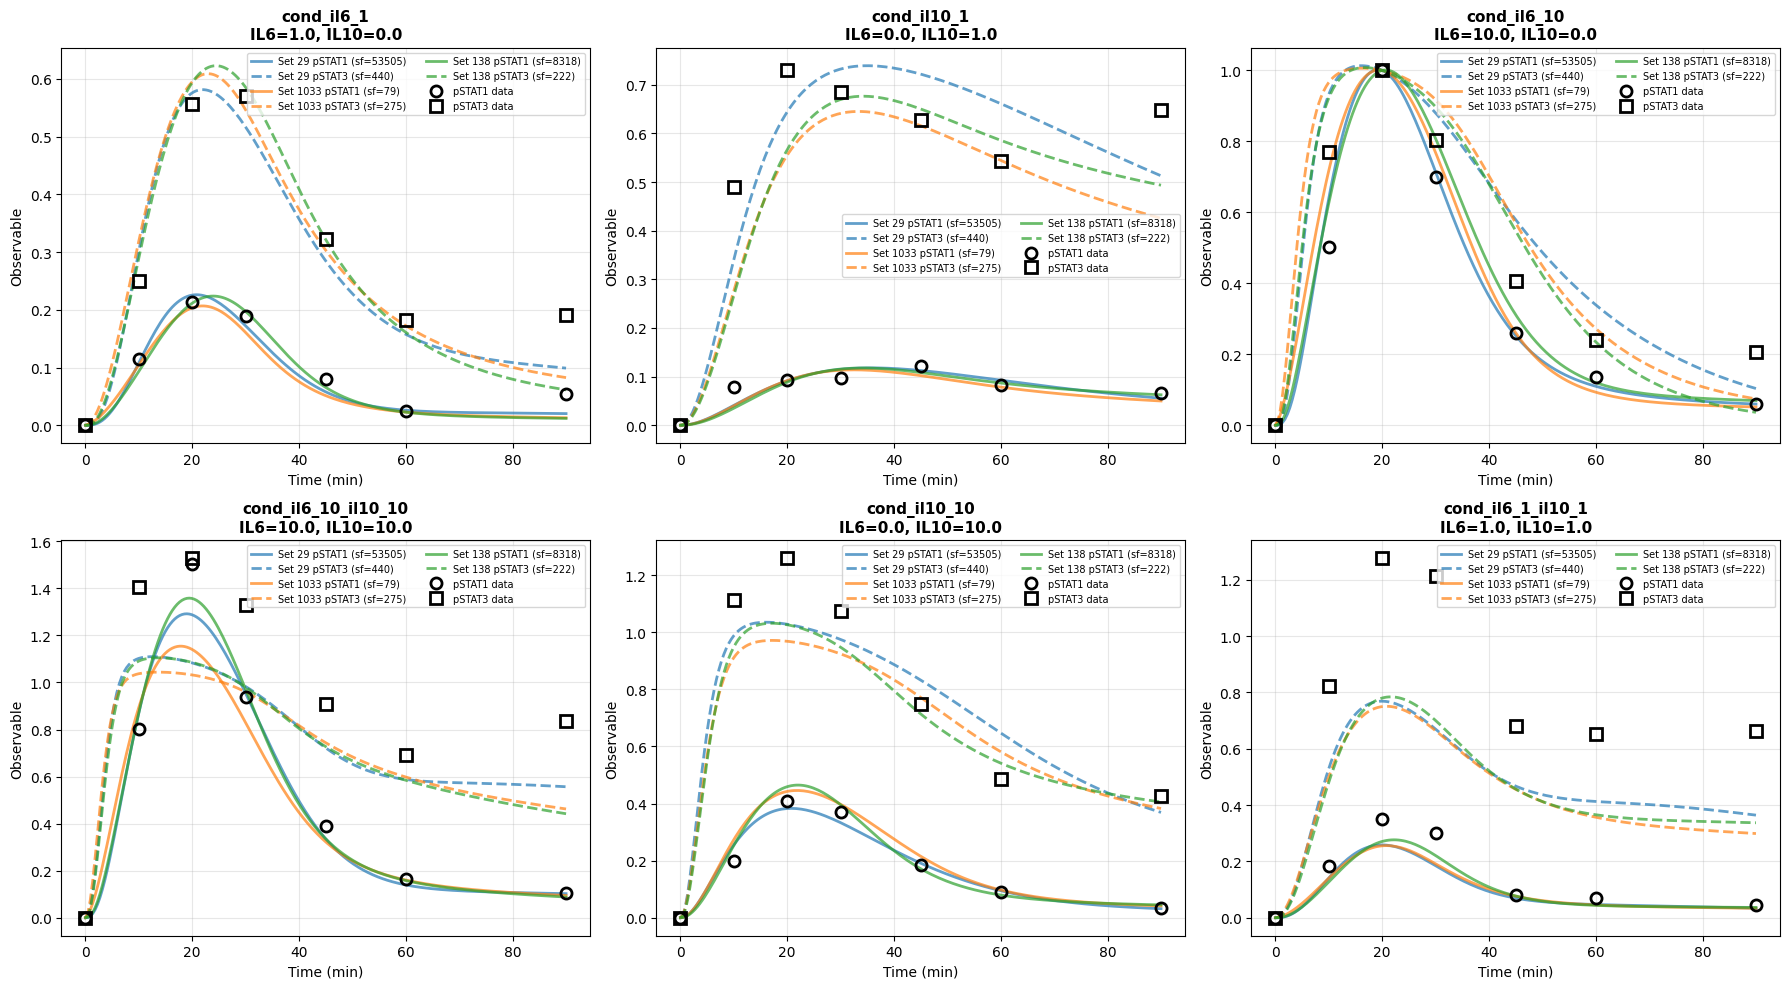


NLLH values for tested parameter sets:
  Set 29: NLLH =   -21.74
  Set 1033: NLLH =   127.83
  Set 138: NLLH =   394.20


In [11]:
# Compare parameter sets across all conditions
import matplotlib.pyplot as plt

indices_to_test = [29, 1033, 138]
colors = ['C0', 'C1', 'C2']

# Simulate all parameter sets
all_results = []
all_scaling_factors = []

for idx in indices_to_test:
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    param_vector = estimator.params_to_vector(fitted_dict_subset)
    results, (sf_pSTAT1, sf_pSTAT3) = estimator.simulate_conditions(param_vector)
    all_results.append(results)
    all_scaling_factors.append((sf_pSTAT1, sf_pSTAT3))

# Create figure with subplots for each condition
n_conditions = len(conditions_df)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each condition
for cond_idx, cond_id in enumerate(conditions_df['conditionId']):
    ax = axes[cond_idx]
    
    # Get condition info
    cond_row = conditions_df[conditions_df['conditionId'] == cond_id].iloc[0]
    
    # Plot results from each parameter set
    for i, idx in enumerate(indices_to_test):
        results = all_results[i]
        sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[i]
        
        # Plot pSTAT1 and pSTAT3
        ax.plot(results[cond_id]['time'], sf_pSTAT1 * results[cond_id]['total_pS1'],
               '-', color=colors[i], alpha=0.7, linewidth=2, 
               label=f'Set {idx} pSTAT1 (sf={sf_pSTAT1:.0f})')
        ax.plot(results[cond_id]['time'], sf_pSTAT3 * results[cond_id]['total_pS3'],
               '--', color=colors[i], alpha=0.7, linewidth=2,
               label=f'Set {idx} pSTAT3 (sf={sf_pSTAT3:.0f})')
    
    # Overlay experimental data
    cond_data = measurements_df[measurements_df['simulationConditionId'] == cond_id]
    
    # pSTAT1 data
    pS1_data = cond_data[cond_data['observableId'] == 'obs_total_pS1']
    if len(pS1_data) > 0:
        ax.plot(pS1_data['time'], pS1_data['measurement'],
               'o', color='black', markersize=8, markeredgewidth=2,
               markerfacecolor='none', label='pSTAT1 data')
    
    # pSTAT3 data
    pS3_data = cond_data[cond_data['observableId'] == 'obs_total_pS3']
    if len(pS3_data) > 0:
        ax.plot(pS3_data['time'], pS3_data['measurement'],
               's', color='black', markersize=8, markeredgewidth=2,
               markerfacecolor='none', label='pSTAT3 data')
    
    ax.set_title(f"{cond_id}\nIL6={cond_row['L1_0']}, IL10={cond_row['L2_0']}", fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (min)', fontsize=10)
    ax.set_ylabel('Observable', fontsize=10)
    ax.legend(fontsize=7, loc='best', ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print NLLH values for comparison
print("\nNLLH values for tested parameter sets:")
for idx in indices_to_test:
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    param_vector = estimator.params_to_vector(fitted_dict_subset)
    nllh = estimator.compute_nllh(param_vector, verbose=False)
    print(f"  Set {idx:2d}: NLLH = {nllh:8.2f}")

## Compare with Best Fit from bestfit.csv

Compare the best fit from the external optimization with parameter sets from param_sets.csv

Loaded best fit with 46 parameters

Computed scaling factors: sf_pSTAT1=1.04, sf_pSTAT3=1.00
NLLH = -116.2464 (84 datapoints)

Best fit NLLH: -116.25



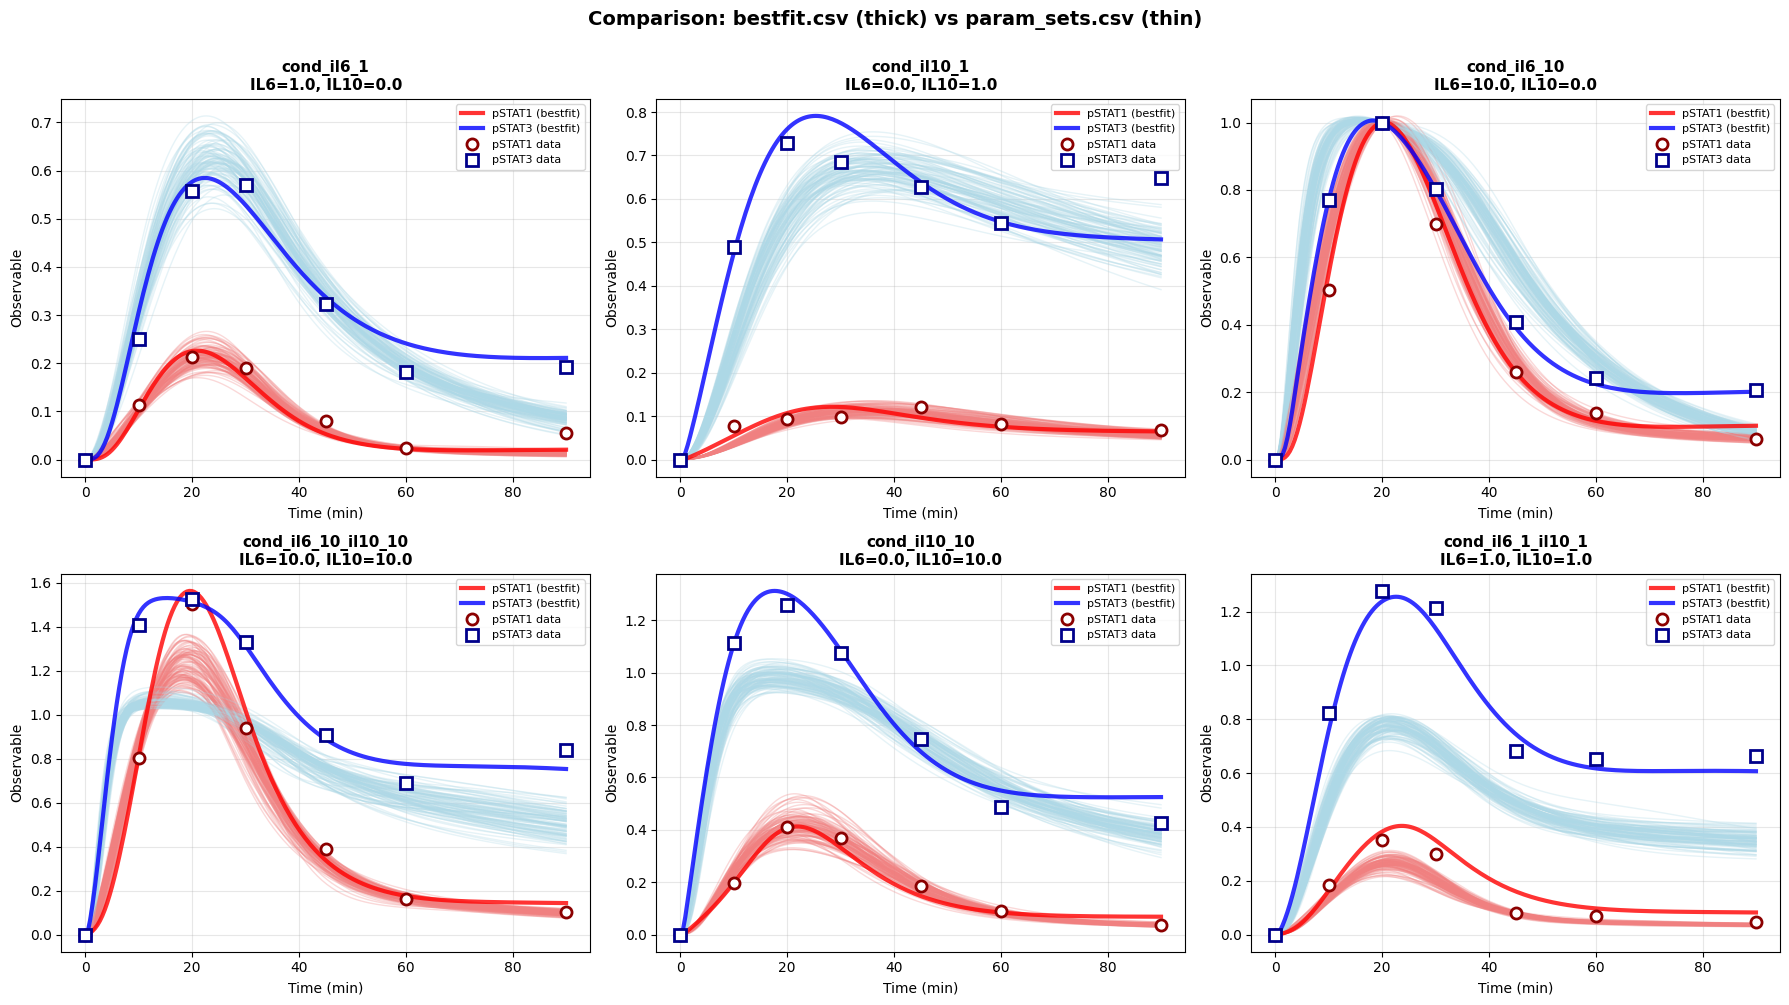


SUMMARY
Source                     NLLH    sf_pSTAT1    sf_pSTAT3
----------------------------------------------------------------------
bestfit.csv             -116.25          1.0          1.0
----------------------------------------------------------------------
param_sets #224          167.78      10199.0        240.6
param_sets #86           130.65       7460.2        654.4
param_sets #1207         105.80        306.1        765.8
param_sets #280          197.26       4406.1        426.6
param_sets #548          150.83        710.6        212.9
param_sets #655           71.63        269.2         57.0
param_sets #603          145.09        326.2         90.6
param_sets #922           66.33         65.1         78.1
param_sets #525           86.67        440.1        222.9
param_sets #1187         203.55        190.3        578.9
param_sets #1129          94.01        140.1        513.3
param_sets #1348         132.22         37.4        535.3
param_sets #290          160.95      

In [15]:
# Load bestfit.csv and compare with param_sets.csv results
import matplotlib.pyplot as plt

# Load bestfit parameters (already in log10 space)
bestfit_df = pd.read_csv('bestfit.csv')
print(f"Loaded best fit with {len(bestfit_df)} parameters\n")

# Create parameter vector from bestfit.csv
# The values are already in estimation space (log10)
bestfit_vector = np.zeros(len(estimator.estimable_params))
for i, param_name in enumerate(estimator.estimable_params):
    param_row = bestfit_df[bestfit_df['parameter'] == param_name]
    if len(param_row) > 0:
        bestfit_vector[i] = param_row['value'].values[0]
    else:
        # Use nominal value if parameter not in bestfit
        print(f"Warning: {param_name} not in bestfit.csv, using nominal value")
        nominal = estimator.param_info[param_name]['nominal']
        if estimator.param_info[param_name]['scale'] == 'log10':
            bestfit_vector[i] = np.log10(nominal)
        else:
            bestfit_vector[i] = nominal

# Compute NLLH for bestfit
bestfit_nllh = estimator.compute_nllh(bestfit_vector, verbose=True)
print(f"\nBest fit NLLH: {bestfit_nllh:.2f}\n")

# Compare with top 3 parameter sets from param_sets.csv
#indices_to_compare = [29, 1033, 138]  # Same as before
# 100 random sets from param_sets.csv
indices_to_compare = np.random.choice(len(param_sets_df), size=100, replace=False)

# Simulate param_sets FIRST
all_results = []
all_scaling_factors = []
all_nllh = []

for idx in indices_to_compare:
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    param_vector = estimator.params_to_vector(fitted_dict_subset)
    results, (sf_pSTAT1, sf_pSTAT3) = estimator.simulate_conditions(param_vector)
    nllh = estimator.compute_nllh(param_vector, verbose=False)
    
    all_results.append(results)
    all_scaling_factors.append((sf_pSTAT1, sf_pSTAT3))
    all_nllh.append(nllh)

# Now simulate bestfit and INSERT at the beginning
bestfit_results, (bestfit_sf_pSTAT1, bestfit_sf_pSTAT3) = estimator.simulate_conditions(bestfit_vector)
all_results.insert(0, bestfit_results)
all_scaling_factors.insert(0, (bestfit_sf_pSTAT1, bestfit_sf_pSTAT3))
all_nllh.insert(0, bestfit_nllh)

# Create figure with subplots for each condition
n_conditions = len(conditions_df)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each condition
for cond_idx, cond_id in enumerate(conditions_df['conditionId']):
    ax = axes[cond_idx]
    
    # Get condition info
    cond_row = conditions_df[conditions_df['conditionId'] == cond_id].iloc[0]
    
    # Plot param_sets results first (thin lines, in background)
    for i in range(1, len(all_results)):
        results = all_results[i]
        sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[i]
        
        # Plot pSTAT1 (light red, thin)
        ax.plot(results[cond_id]['time'], sf_pSTAT1 * results[cond_id]['total_pS1'],
               '-', color='lightcoral', alpha=0.3, linewidth=1.0)
        # Plot pSTAT3 (light blue, thin)
        ax.plot(results[cond_id]['time'], sf_pSTAT3 * results[cond_id]['total_pS3'],
               '-', color='lightblue', alpha=0.3, linewidth=1.0)
    
    # Plot bestfit result (thick lines, on top)
    results = all_results[0]
    sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[0]
    
    # Plot pSTAT1 (red, thick)
    ax.plot(results[cond_id]['time'], sf_pSTAT1 * results[cond_id]['total_pS1'],
           '-', color='red', alpha=0.8, linewidth=3.0, label='pSTAT1 (bestfit)')
    # Plot pSTAT3 (blue, thick)
    ax.plot(results[cond_id]['time'], sf_pSTAT3 * results[cond_id]['total_pS3'],
           '-', color='blue', alpha=0.8, linewidth=3.0, label='pSTAT3 (bestfit)')
    
    # Overlay experimental data
    cond_data = measurements_df[measurements_df['simulationConditionId'] == cond_id]
    
    # pSTAT1 data
    pS1_data = cond_data[cond_data['observableId'] == 'obs_total_pS1']
    if len(pS1_data) > 0:
        ax.plot(pS1_data['time'], pS1_data['measurement'],
               'o', color='darkred', markersize=8, markeredgewidth=2,
               markerfacecolor='white', label='pSTAT1 data', zorder=10)
    
    # pSTAT3 data
    pS3_data = cond_data[cond_data['observableId'] == 'obs_total_pS3']
    if len(pS3_data) > 0:
        ax.plot(pS3_data['time'], pS3_data['measurement'],
               's', color='darkblue', markersize=8, markeredgewidth=2,
               markerfacecolor='white', label='pSTAT3 data', zorder=10)
    
    ax.set_title(f"{cond_id}\nIL6={cond_row['L1_0']}, IL10={cond_row['L2_0']}", 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (min)', fontsize=10)
    ax.set_ylabel('Observable', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison: bestfit.csv (thick) vs param_sets.csv (thin)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"{'Source':<20} {'NLLH':>10} {'sf_pSTAT1':>12} {'sf_pSTAT3':>12}")
print("-"*70)
sf1, sf3 = all_scaling_factors[0]
print(f"{'bestfit.csv':<20} {all_nllh[0]:>10.2f} {sf1:>12.1f} {sf3:>12.1f}")
print("-"*70)
for i, idx in enumerate(indices_to_compare, start=1):
    sf1, sf3 = all_scaling_factors[i]
    print(f"{'param_sets #' + str(idx):<20} {all_nllh[i]:>10.2f} {sf1:>12.1f} {sf3:>12.1f}")
print("="*70)
best_idx = np.argmin(all_nllh)
label = 'bestfit.csv' if best_idx == 0 else f'param_sets #{indices_to_compare[best_idx-1]}'
print(f"\nBest NLLH: {all_nllh[best_idx]:.2f} from {label}")